In [5]:
import requests
import geopandas as gpd
import pandas as pd
import mapclassify as mc
import zipfile
import io
import os
import matplotlib.pyplot as plt
from shapely.geometry import Point,Polygon
#%matplotlib inline

In [6]:
from bokeh.tile_providers import STAMEN_TERRAIN, CARTODBPOSITRON_RETINA
from bokeh.io import output_notebook, show, output_file, save
from bokeh.plotting import figure
from bokeh.models import (ColumnDataSource,HoverTool,LogColorMapper)
from bokeh.palettes import RdYlBu11 as palette
import geopandas as gpd
import pysal as ps
#output_notebook()

/Users/aierfanmaierdan/opt/anaconda3/lib/python3.7/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/Users/aierfanmaierdan/opt/anaconda3/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [7]:
url = 'http://www2.census.gov/geo/tiger/TIGER2017/STATE/tl_2017_us_state.zip'

print('Downloading shapefile...')

%time r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path='tmp/') # extract to folder - this is a pretty big file
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)



CPU times: user 358 ms, sys: 91.1 ms, total: 449 ms
Wall time: 3.92 s
Done
['tl_2017_us_state.dbf', 'tl_2017_us_state.prj', 'tl_2017_us_state.shp', 'tl_2017_us_state.shx']


In [8]:
dbf, prj, shp, shx = [filename for filename in filenames]
usa = gpd.read_file('tmp/'+shp)
print("Shape of the dataframe: {}".format(usa.shape))
print("Projection of dataframe: {}".format(usa.crs))

Shape of the dataframe: (56, 15)
Projection of dataframe: {'init': 'epsg:4269'}


In [9]:
stfips = pd.read_csv('../dataset/ContiguousStFips.csv')
usa = usa[usa.STATEFP.astype('int').isin(stfips.STFIPS)].reset_index()
usa = usa.to_crs({'init': 'epsg:3857'})

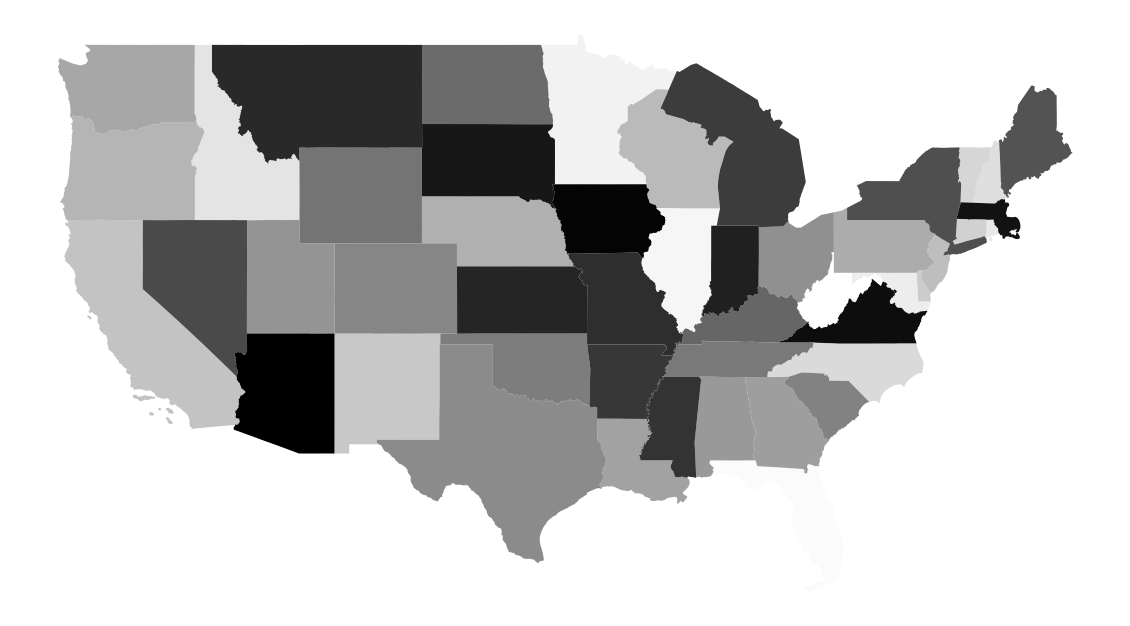

In [7]:

fig, ax = plt.subplots(figsize=(20,20), subplot_kw=dict(aspect='equal'))
usa.plot(column='index', cmap='binary',  ax=ax);
ax.set_axis_off()

In [8]:
sentimentDF = pd.read_csv('4.csv')
sentimentDF.columns = ['city','sentiment_mean','count','y','x']

geo = [Point(xy)for xy in zip(sentimentDF['x'],sentimentDF['y'])]

gdf = gpd.GeoDataFrame(
    sentimentDF, geometry=geo)

In [9]:
gdf.head()

,city,sentiment_mean,count,y,x,geometry
0,Abilene,0.898213,1,32.45,-99.74,POINT (-99.73999999999999 32.45)
1,Akron,0.299466,2,41.08,-81.52,POINT (-81.52 41.08)
2,Albany,-0.384718,4,42.67,-73.80,POINT (-73.8 42.67)
3,Albuquerque,-0.061220,6,35.12,-106.62,POINT (-106.62 35.12)
4,Alexandria,0.143885,7,38.82,-77.09,POINT (-77.09 38.82)


In [10]:
geom =gdf.geometry.name


In [11]:
gdf.head()

,city,sentiment_mean,count,y,x,geometry
0,Abilene,0.898213,1,32.45,-99.74,POINT (-99.73999999999999 32.45)
1,Akron,0.299466,2,41.08,-81.52,POINT (-81.52 41.08)
2,Albany,-0.384718,4,42.67,-73.80,POINT (-73.8 42.67)
3,Albuquerque,-0.061220,6,35.12,-106.62,POINT (-106.62 35.12)
4,Alexandria,0.143885,7,38.82,-77.09,POINT (-77.09 38.82)


In [12]:
usa = usa.to_crs({'init': 'epsg:4326'})#convert to 4326
gdf.crs = {'init' :'epsg:4326'}



In [13]:
gdf.head()

,city,sentiment_mean,count,y,x,geometry
0,Abilene,0.898213,1,32.45,-99.74,POINT (-99.73999999999999 32.45)
1,Akron,0.299466,2,41.08,-81.52,POINT (-81.52 41.08)
2,Albany,-0.384718,4,42.67,-73.80,POINT (-73.8 42.67)
3,Albuquerque,-0.061220,6,35.12,-106.62,POINT (-106.62 35.12)
4,Alexandria,0.143885,7,38.82,-77.09,POINT (-77.09 38.82)


In [14]:
sentimentMin = gdf['sentiment_mean'].min()
sentimentMax = gdf['sentiment_mean'].max()
gdf['sentiment_MMN'] = (gdf['sentiment_mean']-sentimentMin)/(sentimentMax-sentimentMin)

In [15]:
countMin = gdf['count'].min()
countMax = gdf['count'].max()
gdf['count_MMN'] = (gdf['count']-countMin)/(countMax-countMin)

In [16]:
gdf.head(100)

,city,sentiment_mean,count,y,x,geometry,sentiment_MMN,count_MMN
0,Abilene,0.898213,1,32.45,-99.74,POINT (-99.73999999999999 32.45),0.972645,0.000000
1,Akron,0.299466,2,41.08,-81.52,POINT (-81.52 41.08),0.664803,0.007874
2,Albany,-0.384718,4,42.67,-73.80,POINT (-73.8 42.67),0.313034,0.023622
3,Albuquerque,-0.061220,6,35.12,-106.62,POINT (-106.62 35.12),0.479359,0.039370
4,Alexandria,0.143885,7,38.82,-77.09,POINT (-77.09 38.82),0.584812,0.047244
...,...,...,...,...,...,...,...,...
95,Mobile,0.226345,12,30.68,-88.09,POINT (-88.09 30.68),0.627208,0.086614
96,Modesto,0.653860,1,37.66,-120.99,POINT (-120.99 37.66),0.847013,0.000000
97,Montgomery,-0.304492,4,32.35,-86.28,POINT (-86.28 32.35),0.354282,0.023622
98,Naperville,-0.094155,18,41.76,-88.15,POINT (-88.15000000000001 41.76),0.462425,0.133858


In [17]:
usa.head()

,index,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62265662566,489840834,+38.6472854,-080.6183274,POLYGON ((-81.74725399999998 39.09537899907642...
1,1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138911437206,31398800291,+28.4574302,-082.4091478,"(POLYGON ((-82.987477 24.62537899928464, -82.9..."
2,2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143784114293,6211277447,+40.1028754,-089.1526108,POLYGON ((-91.18529499999998 40.63780299906744...
3,3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206229176104,18944967530,+46.3158148,-094.1996628,"POLYGON ((-96.784381 46.63050399905836, -96.78..."
4,4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25150696145,6980371026,+38.9466584,-076.6744939,"POLYGON ((-77.45880799999999 39.2202699990756,..."


In [18]:
gdf.head()


,city,sentiment_mean,count,y,x,geometry,sentiment_MMN,count_MMN
0,Abilene,0.898213,1,32.45,-99.74,POINT (-99.73999999999999 32.45),0.972645,0.000000
1,Akron,0.299466,2,41.08,-81.52,POINT (-81.52 41.08),0.664803,0.007874
2,Albany,-0.384718,4,42.67,-73.80,POINT (-73.8 42.67),0.313034,0.023622
3,Albuquerque,-0.061220,6,35.12,-106.62,POINT (-106.62 35.12),0.479359,0.039370
4,Alexandria,0.143885,7,38.82,-77.09,POINT (-77.09 38.82),0.584812,0.047244


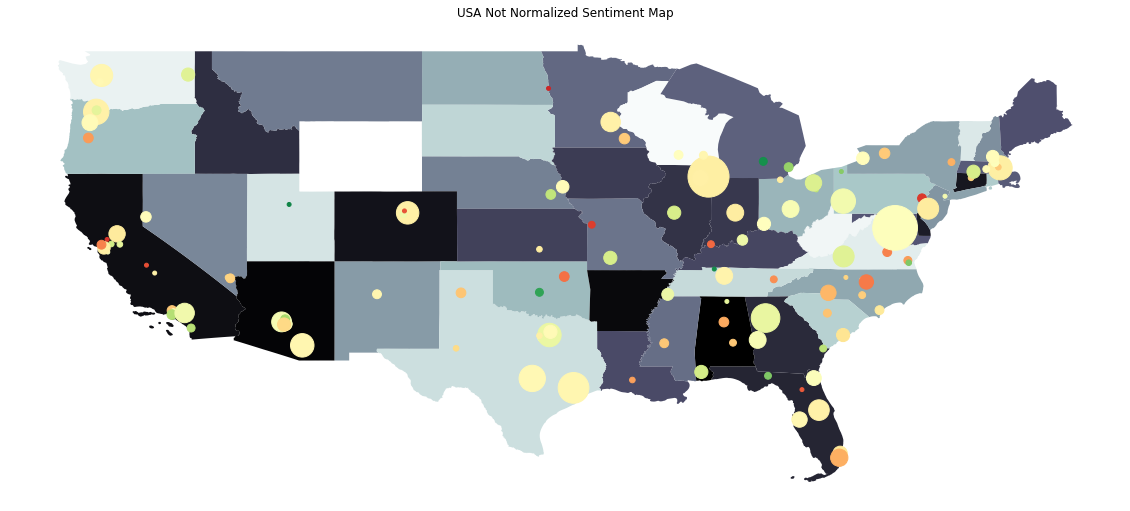

In [19]:

fig1, ax1 = plt.subplots(figsize=(20,20), subplot_kw=dict(aspect='equal'))
usa.plot(column='GEOID', cmap='bone',  ax=ax1);
gdf.plot(column='sentiment_mean',cmap='RdYlGn',vmin=-1, vmax=1, ax=ax1, markersize=gdf['count_MMN']*2000);
ax1.set_axis_off()
plt.title('USA Not Normalized Sentiment Map')
plt.savefig('../result/NotNormalizedMapOutput.png')

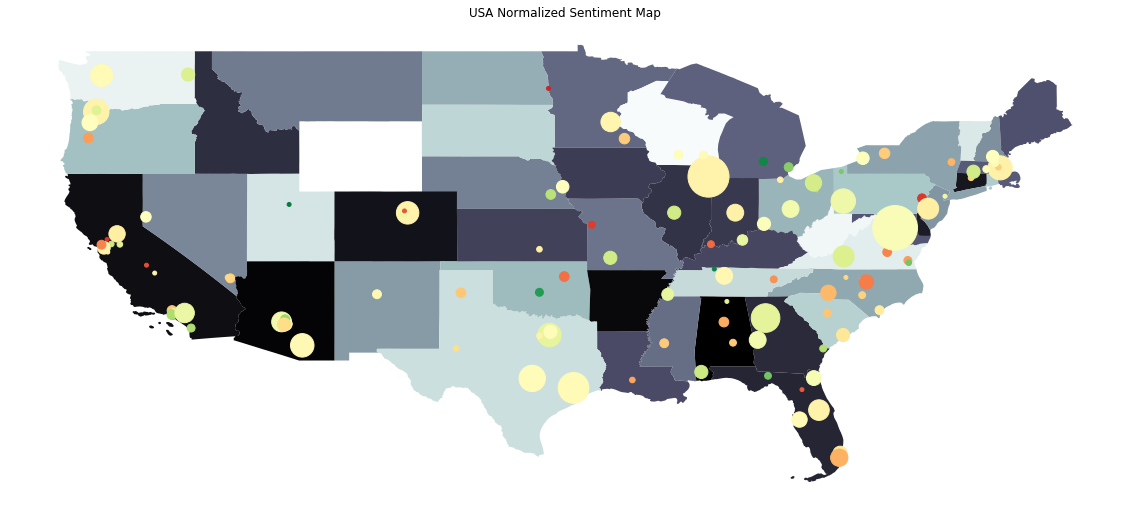

In [20]:
fig, ax = plt.subplots(figsize=(20,20), subplot_kw=dict(aspect='equal'))
usa.plot(column='GEOID', cmap='bone',  ax=ax);
gdf.plot(column='sentiment_MMN',cmap='RdYlGn',  ax=ax, markersize=gdf['count_MMN']*2000);
ax.set_axis_off()
plt.title('USA Normalized Sentiment Map')
plt.savefig('../result/NormalizedMapOutput.png')

In [21]:
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import get_provider, Vendors
import bokeh.models as bmo
from bokeh.models import LinearColorMapper
from bokeh.palettes import RdYlGn
import numpy as np
TOOLS="pan,wheel_zoom,box_zoom,reset,save"

gdf = gdf.to_crs({'init': 'epsg:3857'})
output_file("../result/InteractiveMapOutput.html")

cmaper= LinearColorMapper(palette = RdYlGn[3])
k = 6378137
gdf["x1"] = gdf['x'] * (k * np.pi/180.0)
gdf["y1"] = np.log(np.tan((90 + gdf['y']) * np.pi/360.0)) * k
        
        
tile_provider = get_provider(Vendors.CARTODBPOSITRON)
p = figure(x_range=(-14000000, -8000000), y_range=(3000000, 7000000),
           x_axis_type="mercator", y_axis_type="mercator")

source = ColumnDataSource(data=dict(longitude=gdf['x1'], nname = gdf['city'],nsize=gdf['count'],sentRound = round(gdf['sentiment_mean'], 2), nSS= gdf['sentiment_mean'],latitude=gdf['y1'],size = 4+(30*gdf['count_MMN'])))

p.add_tile(tile_provider)
circles = p.circle(x='longitude', y='latitude',size='size', color = {'field':'nSS','transform':cmaper},source=source)

p_hover = HoverTool(renderers=[circles])
p_hover.point_policy = "follow_mouse"
p_hover.tooltips=[
    ("City", "@nname"),
    ("tweet count", "@nsize"),
    ("sentiment Score","@sentRound")
]

p.add_tools(p_hover)


show(p)

In [22]:
gdf[140:]

,city,sentiment_mean,count,y,x,geometry,sentiment_MMN,count_MMN,x1,y1
140,Spokane,0.160352,12,47.67,-117.41,POINT (-13070021.41403825 6052129.136259906),0.593278,0.086614,-1.307002e+07,6.052129e+06
141,Springfield,0.204625,12,42.12,-72.54,POINT (-8075115.862144065 5178971.845629443),0.616041,0.086614,-8.075116e+06,5.178972e+06
142,Springfield,0.204625,12,37.20,-93.29,POINT (-10384995.29610449 4467020.993627968),0.616041,0.086614,-1.038500e+07,4.467021e+06
143,Springfield,0.204625,12,39.78,-89.64,POINT (-9978679.154709043 4834023.79239465),0.616041,0.086614,-9.978679e+06,4.834024e+06
144,Stamford,0.407572,1,41.10,-73.55,POINT (-8187548.54784527 5027102.849122582),0.720385,0.000000,-8.187549e+06,5.027103e+06
145,Stockton,0.135491,3,37.97,-121.31,POINT (-13504167.42813202 4575188.685434621),0.580496,0.015748,-1.350417e+07,4.575189e+06
146,Sunnyvale,0.627055,1,37.39,-122.03,POINT (-13584317.46150317 4493608.075140049),0.833231,0.000000,-1.358432e+07,4.493608e+06
147,Syracuse,-0.993563,1,43.04,-76.14,POINT (-8475866.028999848 5318062.238002291),0.000000,0.000000,-8.475866e+06,5.318062e+06
148,Tacoma,-0.044537,4,47.25,-122.46,POINT (-13632184.84254428 5982976.332951714),0.487936,0.023622,-1.363218e+07,5.982976e+06
149,Tallahassee,0.518853,4,30.46,-84.28,POINT (-9382006.684057096 3562816.65693683),0.777600,0.023622,-9.382007e+06,3.562817e+06
